# Imports et configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc
import warnings
warnings.filterwarnings('ignore')

# Configuration globale
WINDOW_SIZE = 500
OVERLAP = 0.8
STEP_SIZE = int(WINDOW_SIZE * (1 - OVERLAP))
RANDOM_STATE = 42

# Configuration GPU (optionnel)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("Configuration terminée")
print(f"Window size: {WINDOW_SIZE}")
print(f"Overlap: {OVERLAP*100}%")
print(f"Step size: {STEP_SIZE}")

Configuration terminée
Window size: 500
Overlap: 80.0%
Step size: 99


#  Fonctions de chargement des données

In [2]:
def load_motionsense_data(data_path):
    """
    Charge les données MotionSense depuis la structure de dossiers
    data_path/activity/user_X.csv
    """
    data_path = Path(data_path)
    all_data = []
    
    # Parcourir tous les sous-dossiers (activités)
    for activity_folder in data_path.iterdir():
        if not activity_folder.is_dir():
            continue
            
        activity_name = activity_folder.name
        print(f"Chargement activité: {activity_name}")
        
        # Parcourir tous les fichiers CSV dans le dossier
        csv_files = list(activity_folder.glob("*.csv"))
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                df['activity'] = activity_name
                df['user'] = csv_file.stem
                all_data.append(df)
            except Exception as e:
                print(f"  Erreur lecture {csv_file.name}: {e}")
        
        print(f"  {len(csv_files)} fichiers chargés")
    
    # Combiner toutes les données
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Garder uniquement les colonnes de capteurs
    sensor_cols = ['attitude.roll', 'attitude.pitch', 'attitude.yaw',
                   'gravity.x', 'gravity.y', 'gravity.z',
                   'rotationRate.x', 'rotationRate.y', 'rotationRate.z',
                   'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    
    available_cols = [col for col in sensor_cols if col in combined_df.columns]
    final_cols = available_cols + ['activity', 'user']
    
    return combined_df[final_cols]

print("Fonctions de chargement définies")

Fonctions de chargement définies


# Chargement et exploration des données

In [3]:
# Remplacer par le chemin vers votre dataset
DATA_PATH = "C:\\Users\\michael\\Downloads\\archive\\A_DeviceMotion_data\\A_DeviceMotion_data"  # À MODIFIER

print("Chargement des données...")
df = load_motionsense_data(DATA_PATH)

print(f"\n{'='*60}")
print("EXPLORATION DES DONNÉES")
print(f"{'='*60}")
print(f"Nombre total d'échantillons: {len(df):,}")
print(f"Nombre de colonnes: {len(df.columns)}")
print(f"\nColonnes disponibles:")
print(df.columns.tolist())

print(f"\n{'='*30}")
print("ACTIVITÉS")
print(f"{'='*30}")
print(df['activity'].value_counts())

print(f"\n{'='*30}")
print("UTILISATEURS")
print(f"{'='*30}")
print(f"Nombre d'utilisateurs uniques: {df['user'].nunique()}")

print(f"\n{'='*30}")
print("APERÇU DES DONNÉES")
print(f"{'='*30}")
print(df.head())

print(f"\nStatistiques descriptives:")
print(df.describe())

Chargement des données...
Chargement activité: dws_1
  24 fichiers chargés
Chargement activité: dws_11
  24 fichiers chargés
Chargement activité: dws_2
  24 fichiers chargés
Chargement activité: jog_16
  24 fichiers chargés
Chargement activité: jog_9
  24 fichiers chargés
Chargement activité: sit_13
  24 fichiers chargés
Chargement activité: sit_5
  24 fichiers chargés
Chargement activité: std_14
  24 fichiers chargés
Chargement activité: std_6
  24 fichiers chargés
Chargement activité: ups_12
  24 fichiers chargés
Chargement activité: ups_3
  24 fichiers chargés
Chargement activité: ups_4
  24 fichiers chargés
Chargement activité: wlk_15
  24 fichiers chargés
Chargement activité: wlk_7
  24 fichiers chargés
Chargement activité: wlk_8
  24 fichiers chargés

EXPLORATION DES DONNÉES
Nombre total d'échantillons: 1,412,865
Nombre de colonnes: 14

Colonnes disponibles:
['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.

# Visualisation des données brutes

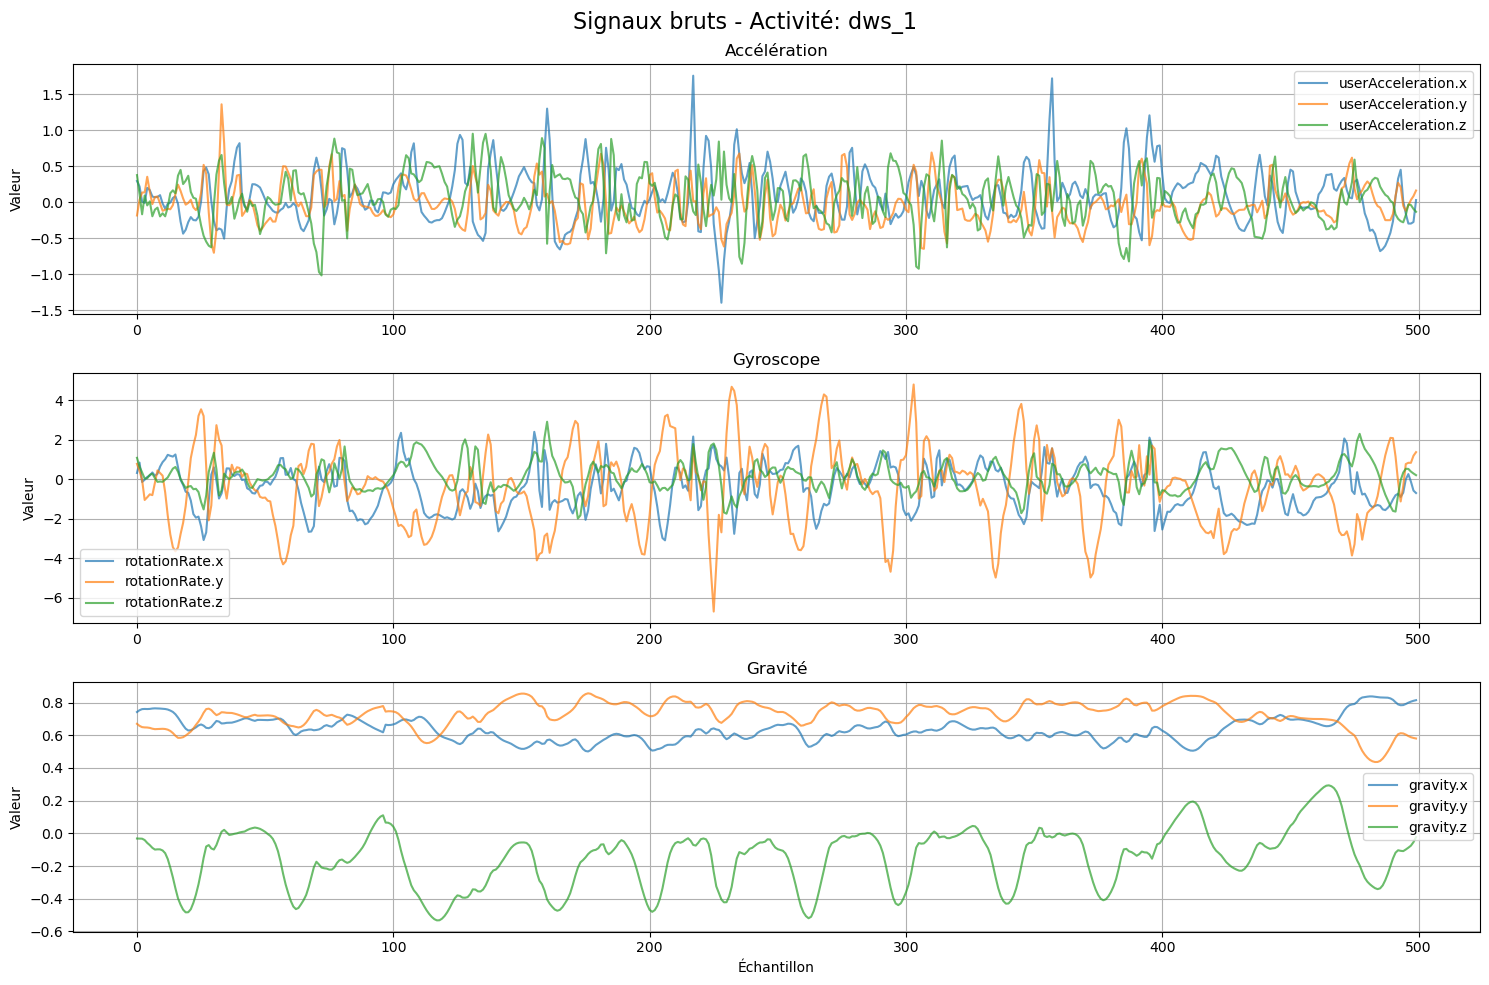

In [4]:
# Sélectionner un échantillon d'une activité
sample_activity = df['activity'].iloc[0]
sample_data = df[df['activity'] == sample_activity].head(500)

# Colonnes de capteurs
sensor_cols = [col for col in df.columns if col not in ['activity', 'user']]

fig, axes = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle(f'Signaux bruts - Activité: {sample_activity}', fontsize=16)

# Accélération
accel_cols = [col for col in sensor_cols if 'Acceleration' in col]
if accel_cols:
    for col in accel_cols:
        axes[0].plot(sample_data[col], label=col, alpha=0.7)
    axes[0].set_title('Accélération')
    axes[0].set_ylabel('Valeur')
    axes[0].legend()
    axes[0].grid(True)

# Gyroscope
gyro_cols = [col for col in sensor_cols if 'rotation' in col.lower()]
if gyro_cols:
    for col in gyro_cols:
        axes[1].plot(sample_data[col], label=col, alpha=0.7)
    axes[1].set_title('Gyroscope')
    axes[1].set_ylabel('Valeur')
    axes[1].legend()
    axes[1].grid(True)

# Gravité
gravity_cols = [col for col in sensor_cols if 'gravity' in col.lower()]
if gravity_cols:
    for col in gravity_cols:
        axes[2].plot(sample_data[col], label=col, alpha=0.7)
    axes[2].set_title('Gravité')
    axes[2].set_ylabel('Valeur')
    axes[2].set_xlabel('Échantillon')
    axes[2].legend()
    axes[2].grid(True)

plt.tight_layout()
plt.show()

# Fonctions de segmentation en fenêtres

In [5]:
def create_windows(df, window_size, step_size):
    """
    Crée des fenêtres glissantes à partir des données
    """
    windows = []
    labels = []
    users = []
    
    # Grouper par utilisateur et activité
    for (user, activity), group in df.groupby(['user', 'activity']):
        # Extraire les colonnes de capteurs
        sensor_cols = [col for col in group.columns if col not in ['activity', 'user']]
        sensor_data = group[sensor_cols].values
        
        # Créer les fenêtres
        num_windows = 0
        for start in range(0, len(sensor_data) - window_size + 1, step_size):
            window = sensor_data[start:start + window_size]
            windows.append(window)
            labels.append(activity)
            users.append(user)
            num_windows += 1
    
    return np.array(windows), np.array(labels), np.array(users)

print("Fonctions de segmentation définies")

Fonctions de segmentation définies


# Création des fenêtres glissantes

In [6]:
print("Création des fenêtres glissantes...")
print(f"Paramètres: window_size={WINDOW_SIZE}, step_size={STEP_SIZE}")

windows, labels, users = create_windows(df, WINDOW_SIZE, STEP_SIZE)

print(f"\n{'='*60}")
print("FENÊTRES CRÉÉES")
print(f"{'='*60}")
print(f"Nombre total de fenêtres: {len(windows):,}")
print(f"Shape des fenêtres: {windows.shape}")
print(f"Nombre de capteurs: {windows.shape[2]}")

# Distribution des labels
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"\nDistribution des fenêtres par activité:")
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count:,} ({count/len(labels)*100:.1f}%)")

# Libérer mémoire
del df
gc.collect()

Création des fenêtres glissantes...
Paramètres: window_size=500, step_size=99

FENÊTRES CRÉÉES
Nombre total de fenêtres: 12,637
Shape des fenêtres: (12637, 500, 12)
Nombre de capteurs: 12

Distribution des fenêtres par activité:
  dws_1: 397 (3.1%)
  dws_11: 120 (0.9%)
  dws_2: 488 (3.9%)
  jog_16: 191 (1.5%)
  jog_9: 944 (7.5%)
  sit_13: 944 (7.5%)
  sit_5: 2,263 (17.9%)
  std_14: 714 (5.7%)
  std_6: 2,160 (17.1%)
  ups_12: 175 (1.4%)
  ups_3: 481 (3.8%)
  ups_4: 612 (4.8%)
  wlk_15: 550 (4.4%)
  wlk_7: 1,492 (11.8%)
  wlk_8: 1,106 (8.8%)


27

# Visualisation d'une fenêtre

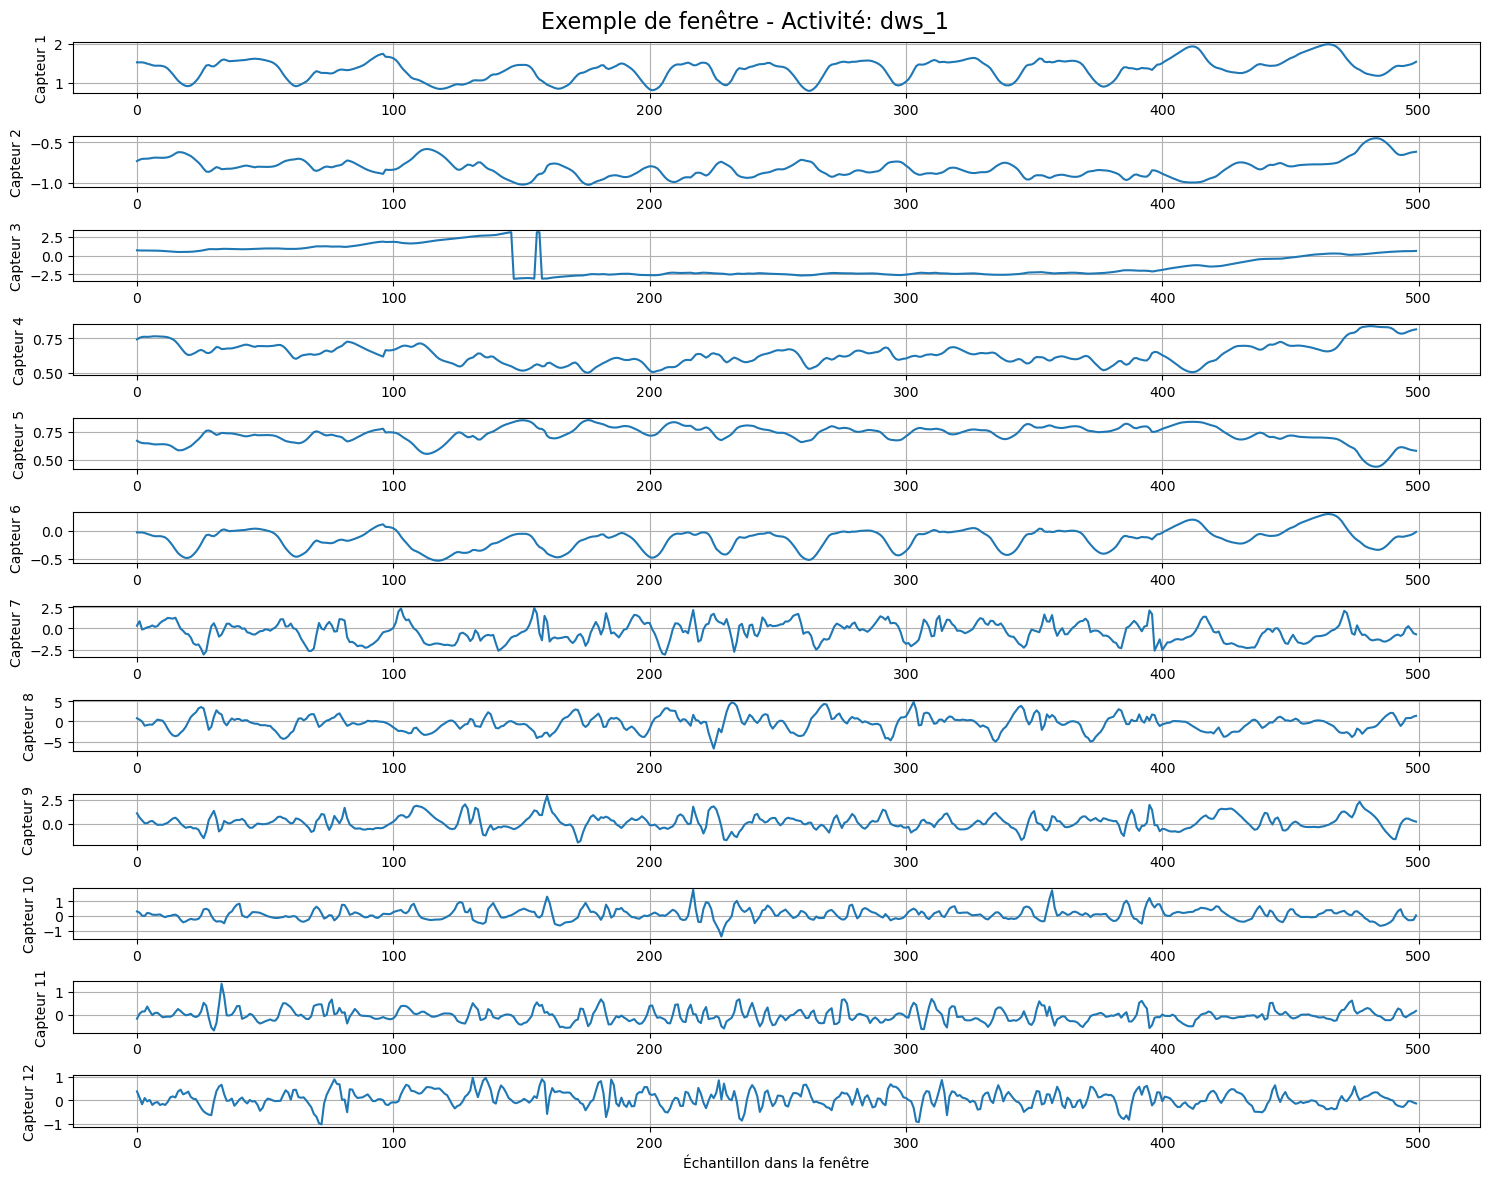

In [7]:
# Visualiser une fenêtre exemple
window_idx = 0
sample_window = windows[window_idx]
sample_label = labels[window_idx]

fig, axes = plt.subplots(windows.shape[2], 1, figsize=(15, 12))
fig.suptitle(f'Exemple de fenêtre - Activité: {sample_label}', fontsize=16)

for i in range(sample_window.shape[1]):
    axes[i].plot(sample_window[:, i])
    axes[i].set_ylabel(f'Capteur {i+1}')
    axes[i].grid(True)

axes[-1].set_xlabel('Échantillon dans la fenêtre')
plt.tight_layout()
plt.show()

# Extraction de caractéristiques pour Random Forest

In [8]:
# ============================================================================
# CELLULE 8: Extraction de caractéristiques pour Random Forest
# ============================================================================

def extract_statistical_features(windows):
    """
    Extrait des caractéristiques statistiques pour Random Forest
    """
    features_list = []
    
    print("Extraction des caractéristiques...")
    for i, window in enumerate(windows):
        if i % 1000 == 0:
            print(f"  Progression: {i}/{len(windows)}")
        
        features = []
        # Pour chaque capteur (colonne)
        for col in range(window.shape[1]):
            signal = window[:, col]
            
            # Caractéristiques temporelles
            features.extend([
                np.mean(signal),
                np.std(signal),
                np.min(signal),
                np.max(signal),
                np.median(signal),
                np.percentile(signal, 25),
                np.percentile(signal, 75),
                np.var(signal),
                np.ptp(signal)  # peak-to-peak
            ])
            
            # Caractéristiques de variation
            if len(signal) > 1:
                diff = np.diff(signal)
                features.extend([
                    np.sum(np.abs(diff)),  # variation totale
                    np.mean(np.abs(diff))  # variation moyenne
                ])
            else:
                features.extend([0, 0])
        
        features_list.append(features)
    
    return np.array(features_list)

print("Fonction d'extraction définie")

Fonction d'extraction définie


# Regroupement et extraction des caractéristiques

In [9]:
# ============================================================================
# CELLULE 9: Regroupement des activités et extraction des caractéristiques
# ============================================================================

print("\n" + "="*60)
print("REGROUPEMENT DES ACTIVITÉS")
print("="*60 + "\n")

print("Labels originaux uniques:")
original_labels = np.unique(labels)
print(original_labels)
print(f"Nombre de labels originaux: {len(original_labels)}")

# Extraire le type d'activité (avant le underscore+nombre)
def extract_activity_type(label):
    """Extrait le type d'activité en enlevant le numéro de session"""
    # Exemples: 'sit_13' -> 'sit', 'wlk_7' -> 'wlk', 'dws_1' -> 'dws'
    parts = label.split('_')
    if len(parts) >= 2:
        # Garder tout sauf le dernier nombre
        activity = parts[0]
        return activity
    return label

# Appliquer le regroupement
labels_grouped = np.array([extract_activity_type(label) for label in labels])

print("\n" + "="*60)
print("Après regroupement:")
unique_grouped = np.unique(labels_grouped)
print(unique_grouped)
print(f"Nombre d'activités: {len(unique_grouped)}")

# Mapping des activités
activity_mapping = {
    'dws': 'Downstairs (Descendre)',
    'ups': 'Upstairs (Monter)',
    'wlk': 'Walking (Marcher)',
    'jog': 'Jogging (Courir)',
    'sit': 'Sitting (Assis)',
    'std': 'Standing (Debout)'
}

print("\nMapping des activités:")
for code, name in activity_mapping.items():
    count = np.sum(labels_grouped == code)
    percentage = count / len(labels_grouped) * 100
    print(f"  {code:3s} -> {name:25s}: {count:5d} fenêtres ({percentage:5.1f}%)")

# Remplacer les labels
labels = labels_grouped.copy()

print(f"\n✅ Labels regroupés avec succès!")
print(f"   {len(original_labels)} labels originaux -> {len(unique_grouped)} activités")

# Libérer mémoire
del labels_grouped, original_labels
gc.collect()

# Extraction des caractéristiques statistiques
print("\n" + "="*60)
print("EXTRACTION DES CARACTÉRISTIQUES")
print("="*60 + "\n")

features = extract_statistical_features(windows)

print(f"\n{'='*60}")
print("CARACTÉRISTIQUES EXTRAITES")
print(f"{'='*60}")
print(f"Shape des caractéristiques: {features.shape}")
print(f"Nombre de caractéristiques par fenêtre: {features.shape[1]}")
print(f"\nStatistiques des caractéristiques:")
print(f"  Min: {features.min():.4f}")
print(f"  Max: {features.max():.4f}")
print(f"  Mean: {features.mean():.4f}")
print(f"  Std: {features.std():.4f}")


REGROUPEMENT DES ACTIVITÉS

Labels originaux uniques:
['dws_1' 'dws_11' 'dws_2' 'jog_16' 'jog_9' 'sit_13' 'sit_5' 'std_14'
 'std_6' 'ups_12' 'ups_3' 'ups_4' 'wlk_15' 'wlk_7' 'wlk_8']
Nombre de labels originaux: 15

Après regroupement:
['dws' 'jog' 'sit' 'std' 'ups' 'wlk']
Nombre d'activités: 6

Mapping des activités:
  dws -> Downstairs (Descendre)   :  1005 fenêtres (  8.0%)
  ups -> Upstairs (Monter)        :  1268 fenêtres ( 10.0%)
  wlk -> Walking (Marcher)        :  3148 fenêtres ( 24.9%)
  jog -> Jogging (Courir)         :  1135 fenêtres (  9.0%)
  sit -> Sitting (Assis)          :  3207 fenêtres ( 25.4%)
  std -> Standing (Debout)        :  2874 fenêtres ( 22.7%)

✅ Labels regroupés avec succès!
   15 labels originaux -> 6 activités

EXTRACTION DES CARACTÉRISTIQUES

Extraction des caractéristiques...
  Progression: 0/12637
  Progression: 1000/12637
  Progression: 2000/12637
  Progression: 3000/12637
  Progression: 4000/12637
  Progression: 5000/12637
  Progression: 6000/12637
 

# Diagnostic de fuite de données

In [10]:
# ============================================================================
# CELLULE 10: Diagnostic de fuite de données
# ============================================================================

print("\n" + "="*60)
print("DIAGNOSTIC DE FUITE DE DONNÉES")
print("="*60 + "\n")

# Vérifier le nombre de fenêtres par utilisateur
user_window_counts = {}
for user in np.unique(users):
    count = np.sum(users == user)
    user_window_counts[user] = count

print("Nombre de fenêtres par utilisateur:")
for user, count in sorted(user_window_counts.items()):
    print(f"  {user}: {count:,} fenêtres")

print(f"\nStatistiques:")
counts = list(user_window_counts.values())
print(f"  Moyenne: {np.mean(counts):.0f} fenêtres/utilisateur")
print(f"  Min: {np.min(counts)} fenêtres/utilisateur")
print(f"  Max: {np.max(counts)} fenêtres/utilisateur")

print(f"\n⚠️  IMPORTANT: Avec {OVERLAP*100}% d'overlap, les fenêtres adjacentes")
print(f"   partagent {int(WINDOW_SIZE*OVERLAP)} échantillons communs!")
print(f"   Un split aléatoire créerait une FUITE DE DONNÉES massive.")
print(f"\n✅ Solution: Split par UTILISATEUR (comme LOSO)")

# Vérifier la distribution des activités regroupées
print("\n" + "="*60)
print("DISTRIBUTION DES ACTIVITÉS REGROUPÉES")
print("="*60 + "\n")
unique_activities, activity_counts = np.unique(labels, return_counts=True)
for activity, count in zip(unique_activities, activity_counts):
    percentage = count / len(labels) * 100
    print(f"  {activity:3s}: {count:5d} fenêtres ({percentage:5.1f}%)")


DIAGNOSTIC DE FUITE DE DONNÉES

Nombre de fenêtres par utilisateur:
  sub_1: 560 fenêtres
  sub_10: 537 fenêtres
  sub_11: 531 fenêtres
  sub_12: 471 fenêtres
  sub_13: 450 fenêtres
  sub_14: 502 fenêtres
  sub_15: 532 fenêtres
  sub_16: 593 fenêtres
  sub_17: 495 fenêtres
  sub_18: 568 fenêtres
  sub_19: 659 fenêtres
  sub_2: 562 fenêtres
  sub_20: 488 fenêtres
  sub_21: 628 fenêtres
  sub_22: 497 fenêtres
  sub_23: 482 fenêtres
  sub_24: 447 fenêtres
  sub_3: 564 fenêtres
  sub_4: 497 fenêtres
  sub_5: 460 fenêtres
  sub_6: 512 fenêtres
  sub_7: 550 fenêtres
  sub_8: 544 fenêtres
  sub_9: 508 fenêtres

Statistiques:
  Moyenne: 527 fenêtres/utilisateur
  Min: 447 fenêtres/utilisateur
  Max: 659 fenêtres/utilisateur

⚠️  IMPORTANT: Avec 80.0% d'overlap, les fenêtres adjacentes
   partagent 400 échantillons communs!
   Un split aléatoire créerait une FUITE DE DONNÉES massive.

✅ Solution: Split par UTILISATEUR (comme LOSO)

DISTRIBUTION DES ACTIVITÉS REGROUPÉES

  dws:  1005 fenêtres (

# Random Forest - Split 70/30

In [11]:
# ============================================================================
# CELLULE 11: Random Forest - Split 70/30 (par utilisateur)
# ============================================================================

print("\n" + "="*60)
print("RANDOM FOREST - SPLIT 70/30 (PAR UTILISATEUR)")
print("="*60 + "\n")

# IMPORTANT: Split par utilisateur pour éviter la fuite de données
unique_users_list = np.unique(users)
n_test_users = max(1, int(len(unique_users_list) * 0.3))

# Sélectionner aléatoirement les utilisateurs de test
np.random.seed(RANDOM_STATE)
test_users = np.random.choice(unique_users_list, size=n_test_users, replace=False)
train_users = np.array([u for u in unique_users_list if u not in test_users])

print(f"Utilisateurs total: {len(unique_users_list)}")
print(f"Utilisateurs train: {len(train_users)} - {train_users}")
print(f"Utilisateurs test: {len(test_users)} - {test_users}")

# Créer les masques train/test basés sur les utilisateurs
train_mask = np.isin(users, train_users)
test_mask = np.isin(users, test_users)

X_train = features[train_mask]
X_test = features[test_mask]
y_train = labels[train_mask]
y_test = labels[test_mask]

print(f"\nDonnées d'entraînement: {len(X_train):,}")
print(f"Données de test: {len(X_test):,}")

# Vérifier la distribution des classes
print("\nDistribution des classes - Train:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {u}: {c:,} ({c/len(y_train)*100:.1f}%)")

print("\nDistribution des classes - Test:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {u}: {c:,} ({c/len(y_test)*100:.1f}%)")

# Normalisation
scaler_split = StandardScaler()
X_train_scaled = scaler_split.fit_transform(X_train)
X_test_scaled = scaler_split.transform(X_test)

# Entraînement
print("\nEntraînement du modèle...")
rf_split = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rf_split.fit(X_train_scaled, y_train)

# Prédiction
y_pred_split = rf_split.predict(X_test_scaled)
accuracy_split = accuracy_score(y_test, y_pred_split)

print(f"\n{'='*60}")
print(f"RÉSULTATS - Split 70/30 (par utilisateur)")
print(f"{'='*60}")
print(f"Précision: {accuracy_split:.4f} ({accuracy_split*100:.2f}%)")
print(f"\nRapport de classification:")
print(classification_report(y_test, y_pred_split))


RANDOM FOREST - SPLIT 70/30 (PAR UTILISATEUR)

Utilisateurs total: 24
Utilisateurs train: 17 - ['sub_10' 'sub_11' 'sub_12' 'sub_13' 'sub_14' 'sub_15' 'sub_16' 'sub_19'
 'sub_20' 'sub_22' 'sub_23' 'sub_3' 'sub_5' 'sub_6' 'sub_7' 'sub_8'
 'sub_9']
Utilisateurs test: 7 - ['sub_17' 'sub_24' 'sub_1' 'sub_4' 'sub_2' 'sub_18' 'sub_21']

Données d'entraînement: 8,880
Données de test: 3,757

Distribution des classes - Train:
  dws: 691 (7.8%)
  jog: 791 (8.9%)
  sit: 2,241 (25.2%)
  std: 2,086 (23.5%)
  ups: 888 (10.0%)
  wlk: 2,183 (24.6%)

Distribution des classes - Test:
  dws: 314 (8.4%)
  jog: 344 (9.2%)
  sit: 966 (25.7%)
  std: 788 (21.0%)
  ups: 380 (10.1%)
  wlk: 965 (25.7%)

Entraînement du modèle...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s



RÉSULTATS - Split 70/30 (par utilisateur)
Précision: 0.9465 (94.65%)

Rapport de classification:
              precision    recall  f1-score   support

         dws       0.98      0.90      0.94       314
         jog       0.97      1.00      0.99       344
         sit       1.00      0.89      0.94       966
         std       0.88      1.00      0.94       788
         ups       0.87      0.98      0.92       380
         wlk       0.97      0.94      0.95       965

    accuracy                           0.95      3757
   macro avg       0.95      0.95      0.95      3757
weighted avg       0.95      0.95      0.95      3757



[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


# Matrice de confusion - Split 70/30

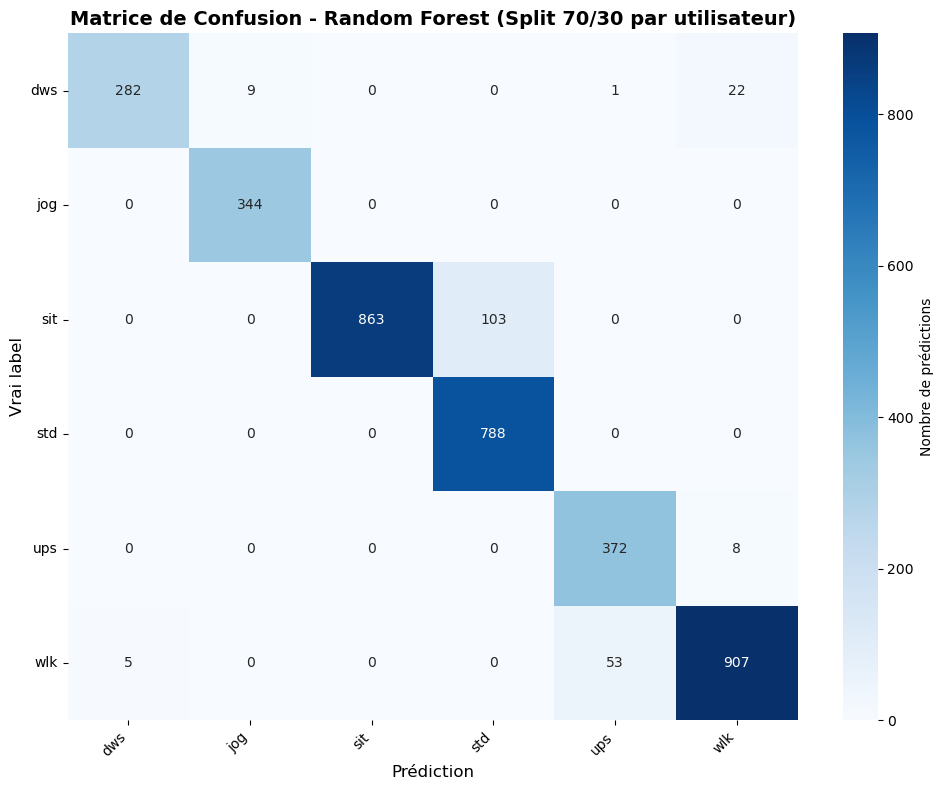


MÉTRIQUES DÉTAILLÉES PAR CLASSE

dws:
  Précision: 0.9826
  Rappel:    0.8981
  F1-Score:  0.9384
  Support:   314

jog:
  Précision: 0.9745
  Rappel:    1.0000
  F1-Score:  0.9871
  Support:   344

sit:
  Précision: 1.0000
  Rappel:    0.8934
  F1-Score:  0.9437
  Support:   966

std:
  Précision: 0.8844
  Rappel:    1.0000
  F1-Score:  0.9387
  Support:   788

ups:
  Précision: 0.8732
  Rappel:    0.9789
  F1-Score:  0.9231
  Support:   380

wlk:
  Précision: 0.9680
  Rappel:    0.9399
  F1-Score:  0.9537
  Support:   965



In [12]:
# ============================================================================
# CELLULE 12: Matrice de confusion - Split 70/30
# ============================================================================

# Matrice de confusion
cm_split = confusion_matrix(y_test, y_pred_split)

# Obtenir les labels uniques pour l'affichage
unique_labels = sorted(np.unique(labels))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_split, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title('Matrice de Confusion - Random Forest (Split 70/30 par utilisateur)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Vrai label', fontsize=12)
plt.xlabel('Prédiction', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Afficher les métriques par classe
print("\n" + "="*60)
print("MÉTRIQUES DÉTAILLÉES PAR CLASSE")
print("="*60 + "\n")

for i, label in enumerate(unique_labels):
    # Calculer précision, rappel, F1-score manuellement
    tp = cm_split[i, i]
    fp = cm_split[:, i].sum() - tp
    fn = cm_split[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{label}:")
    print(f"  Précision: {precision:.4f}")
    print(f"  Rappel:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Support:   {cm_split[i, :].sum()}")
    print()

# Random Forest - Validation LOSO

In [13]:
print("\n" + "="*60)
print("RANDOM FOREST - VALIDATION LOSO")
print("="*60 + "\n")

unique_users = np.unique(users)
print(f"Nombre d'utilisateurs: {len(unique_users)}")

all_predictions = []
all_true_labels = []

for i, test_user in enumerate(unique_users):
    print(f"\nFold {i+1}/{len(unique_users)} - Test user: {test_user}")
    
    # Séparer train/test
    train_mask = users != test_user
    test_mask = users == test_user
    
    X_train_loso = features[train_mask]
    X_test_loso = features[test_mask]
    y_train_loso = labels[train_mask]
    y_test_loso = labels[test_mask]
    
    if len(X_test_loso) == 0:
        print("  Aucune donnée de test, skip")
        continue
    
    print(f"  Train: {len(X_train_loso):,} | Test: {len(X_test_loso):,}")
    
    # Normalisation
    scaler_loso = StandardScaler()
    X_train_scaled_loso = scaler_loso.fit_transform(X_train_loso)
    X_test_scaled_loso = scaler_loso.transform(X_test_loso)
    
    # Entraînement
    rf_loso = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    rf_loso.fit(X_train_scaled_loso, y_train_loso)
    y_pred_loso = rf_loso.predict(X_test_scaled_loso)
    
    fold_accuracy = accuracy_score(y_test_loso, y_pred_loso)
    print(f"  Précision: {fold_accuracy:.4f}")
    
    all_predictions.extend(y_pred_loso)
    all_true_labels.extend(y_test_loso)

# Résultats globaux
accuracy_loso = accuracy_score(all_true_labels, all_predictions)

print(f"\n{'='*60}")
print(f"RÉSULTATS - LOSO")
print(f"{'='*60}")
print(f"Précision globale: {accuracy_loso:.4f} ({accuracy_loso*100:.2f}%)")
print(f"\nRapport de classification:")
print(classification_report(all_true_labels, all_predictions))

# Libérer mémoire
del features, X_train_scaled, X_test_scaled
gc.collect()


RANDOM FOREST - VALIDATION LOSO

Nombre d'utilisateurs: 24

Fold 1/24 - Test user: sub_1
  Train: 12,077 | Test: 560
  Précision: 0.9696

Fold 2/24 - Test user: sub_10
  Train: 12,100 | Test: 537
  Précision: 0.9628

Fold 3/24 - Test user: sub_11
  Train: 12,106 | Test: 531
  Précision: 0.9962

Fold 4/24 - Test user: sub_12
  Train: 12,166 | Test: 471
  Précision: 0.9894

Fold 5/24 - Test user: sub_13
  Train: 12,187 | Test: 450
  Précision: 0.9911

Fold 6/24 - Test user: sub_14
  Train: 12,135 | Test: 502
  Précision: 0.9801

Fold 7/24 - Test user: sub_15
  Train: 12,105 | Test: 532
  Précision: 0.9605

Fold 8/24 - Test user: sub_16
  Train: 12,044 | Test: 593
  Précision: 0.9882

Fold 9/24 - Test user: sub_17
  Train: 12,142 | Test: 495
  Précision: 0.9980

Fold 10/24 - Test user: sub_18
  Train: 12,069 | Test: 568
  Précision: 0.8222

Fold 11/24 - Test user: sub_19
  Train: 11,978 | Test: 659
  Précision: 0.9545

Fold 12/24 - Test user: sub_2
  Train: 12,075 | Test: 562
  Précision

6858

# Matrice de confusion - LOSO

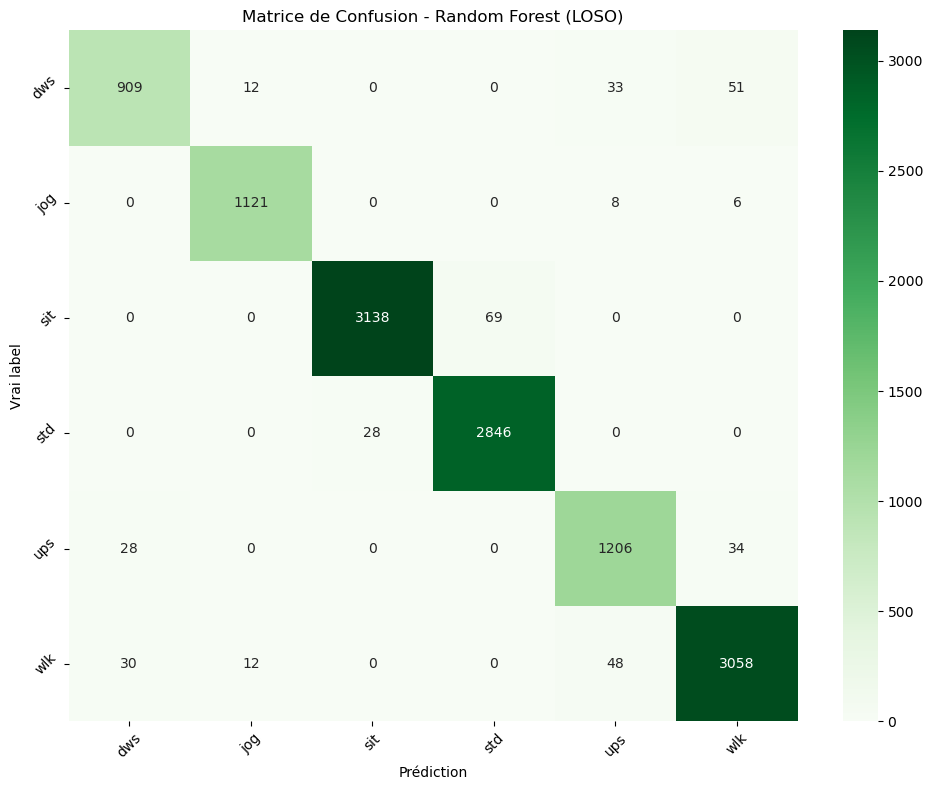

In [14]:
cm_loso = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_loso, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(labels),
            yticklabels=np.unique(labels))
plt.title('Matrice de Confusion - Random Forest (LOSO)')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Architecture CNN 1D

In [15]:
# ============================================================================
# CELLULE 14: Architecture CNN 1D (adaptée pour window_size=500)
# ============================================================================

def build_cnn_model(input_shape, num_classes):
    """
    Construit un CNN 1D avec régularisation pour éviter l'overfitting
    Adapté pour des fenêtres de taille 500
    """
    model = keras.Sequential([
        # Premier bloc convolutionnel
        layers.Conv1D(64, kernel_size=5, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        # Deuxième bloc
        layers.Conv1D(128, kernel_size=5, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        # Troisième bloc (AJOUTÉ pour gérer la taille 500)
        layers.Conv1D(256, kernel_size=3, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.4),
        
        # Quatrième bloc (NOUVEAU pour taille 500)
        layers.Conv1D(256, kernel_size=3, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.5),
        
        # Couches denses
        layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

print("Architecture CNN définie (adaptée pour WINDOW_SIZE=500)")

Architecture CNN définie (adaptée pour WINDOW_SIZE=500)


# Préparation des données pour le CNN

In [16]:
# ============================================================================
# CELLULE 15: Préparation des données pour le CNN
# ============================================================================

print("\n" + "="*60)
print("PRÉPARATION DES DONNÉES POUR CNN 1D")
print("="*60 + "\n")

# Encoder les labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
num_classes = len(le.classes_)

print(f"Nombre de classes: {num_classes}")
print(f"Classes: {le.classes_}")

# IMPORTANT: Split par utilisateur (pas aléatoire!)
unique_users_cnn = np.unique(users)
n_val_users = max(1, int(len(unique_users_cnn) * 0.2))

# Sélectionner aléatoirement les utilisateurs de validation
np.random.seed(RANDOM_STATE)
val_users_cnn = np.random.choice(unique_users_cnn, size=n_val_users, replace=False)
train_users_cnn = np.array([u for u in unique_users_cnn if u not in val_users_cnn])

print(f"\nUtilisateurs train: {len(train_users_cnn)}")
print(f"Utilisateurs validation: {len(val_users_cnn)}")

# Créer les masques
train_mask_cnn = np.isin(users, train_users_cnn)
val_mask_cnn = np.isin(users, val_users_cnn)

X_train_cnn = windows[train_mask_cnn]
X_val_cnn = windows[val_mask_cnn]
y_train_cnn = y_encoded[train_mask_cnn]
y_val_cnn = y_encoded[val_mask_cnn]

print(f"\nDonnées d'entraînement: {len(X_train_cnn):,}")
print(f"Données de validation: {len(X_val_cnn):,}")

# Vérifier qu'il n'y a pas de fuite d'utilisateurs
assert len(set(train_users_cnn) & set(val_users_cnn)) == 0, "ERREUR: Fuite d'utilisateurs!"
print("✅ Vérification: Aucun utilisateur en commun entre train et validation")

# Normalisation par capteur
print("\nNormalisation des données...")
scaler_cnn = StandardScaler()
X_train_flat = X_train_cnn.reshape(-1, X_train_cnn.shape[-1])
scaler_cnn.fit(X_train_flat)

X_train_cnn_scaled = scaler_cnn.transform(
    X_train_cnn.reshape(-1, X_train_cnn.shape[-1])
).reshape(X_train_cnn.shape)

X_val_cnn_scaled = scaler_cnn.transform(
    X_val_cnn.reshape(-1, X_val_cnn.shape[-1])
).reshape(X_val_cnn.shape)

print(f"Shape après normalisation:")
print(f"  Train: {X_train_cnn_scaled.shape}")
print(f"  Validation: {X_val_cnn_scaled.shape}")

# Libérer mémoire
del X_train_flat, windows
gc.collect()


PRÉPARATION DES DONNÉES POUR CNN 1D

Nombre de classes: 6
Classes: ['dws' 'jog' 'sit' 'std' 'ups' 'wlk']

Utilisateurs train: 20
Utilisateurs validation: 4

Données d'entraînement: 10,638
Données de validation: 1,999
✅ Vérification: Aucun utilisateur en commun entre train et validation

Normalisation des données...
Shape après normalisation:
  Train: (10638, 500, 12)
  Validation: (1999, 500, 12)


6910

# Construction et compilation du CNN

In [17]:
input_shape = (X_train_cnn_scaled.shape[1], X_train_cnn_scaled.shape[2])
print(f"Input shape: {input_shape}")

# Construire le modèle
model_cnn = build_cnn_model(input_shape, num_classes)

# Compiler
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_cnn.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Afficher l'architecture
print("\n" + "="*60)
print("ARCHITECTURE DU MODÈLE CNN")
print("="*60 + "\n")
model_cnn.summary()

Input shape: (500, 12)

ARCHITECTURE DU MODÈLE CNN



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 496, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 496, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 248, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 248, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 244, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 244, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 122, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 122, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 120, 256)            │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 120, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 58, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 58, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             7

 Total params: 376,902 (1.44 MB)

 Trainable params: 375,494 (1.43 MB)

 Non-trainable params: 1,408 (5.50 KB)

# Configuration des callbacks

In [18]:
# Callbacks pour éviter l'overfitting
callbacks_cnn = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configurés:")
print("  - EarlyStopping (patience=15)")
print("  - ReduceLROnPlateau (patience=5, factor=0.5)")

Callbacks configurés:
  - EarlyStopping (patience=15)
  - ReduceLROnPlateau (patience=5, factor=0.5)


# Entraînement du CNN

In [19]:
# ============================================================================
# CELLULE 18: Entraînement du CNN (adapté pour window_size=500)
# ============================================================================

print("\n" + "="*60)
print("ENTRAÎNEMENT DU CNN 1D")
print("="*60 + "\n")

# Adapter le batch size en fonction de la taille des fenêtres
# Pour window_size=500, réduire le batch_size pour éviter les problèmes mémoire
if WINDOW_SIZE >= 500:
    BATCH_SIZE = 16  # Réduit pour window_size=500
    print(f"⚠️  Window size = {WINDOW_SIZE}, batch size réduit à {BATCH_SIZE}")
elif WINDOW_SIZE >= 300:
    BATCH_SIZE = 24
else:
    BATCH_SIZE = 32

print(f"Configuration: window_size={WINDOW_SIZE}, batch_size={BATCH_SIZE}")

history_cnn = model_cnn.fit(
    X_train_cnn_scaled, y_train_cnn,
    validation_data=(X_val_cnn_scaled, y_val_cnn),
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_cnn,
    verbose=1
)

print("\nEntraînement terminé!")


ENTRAÎNEMENT DU CNN 1D

⚠️  Window size = 500, batch size réduit à 16
Configuration: window_size=500, batch_size=16
Epoch 1/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9168 - loss: 0.8941 - val_accuracy: 0.8889 - val_loss: 0.8493 - learning_rate: 0.0010
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9657 - loss: 0.5421 - val_accuracy: 0.9675 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9666 - loss: 0.4019 - val_accuracy: 0.9285 - val_loss: 0.5332 - learning_rate: 0.0010
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9757 - loss: 0.3152 - val_accuracy: 0.9415 - val_loss: 0.4252 - learning_rate: 0.0010
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9762 - loss: 0.2847 - val_accuracy: 0.9510 - val_loss: 0.7278 - learning_rate: 0.0010
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9770 - loss: 0.2631 - val_accuracy: 0.9

# Évaluation du CNN

In [23]:
# ============================================================================
# CELLULE 19: Évaluation du CNN (adapté pour window_size=500)
# ============================================================================

print("\n" + "="*60)
print("ÉVALUATION DU CNN")
print("="*60 + "\n")

# Utiliser le même batch_size que l'entraînement
if WINDOW_SIZE >= 500:
    BATCH_SIZE = 16
elif WINDOW_SIZE >= 300:
    BATCH_SIZE = 24
else:
    BATCH_SIZE = 32

# Évaluation sur validation
val_loss, val_accuracy = model_cnn.evaluate(X_val_cnn_scaled, y_val_cnn, 
                                            batch_size=BATCH_SIZE, verbose=0)
print(f"Perte validation: {val_loss:.4f}")
print(f"Précision validation: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Prédictions
y_pred_cnn = model_cnn.predict(X_val_cnn_scaled, batch_size=BATCH_SIZE, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

print(f"\nRapport de classification:")
print(classification_report(y_val_cnn, y_pred_cnn_classes, target_names=le.classes_))

# Nettoyage mémoire simplifié
gc.collect()
print("\n✓ Mémoire nettoyée")


ÉVALUATION DU CNN

Perte validation: 0.1301
Précision validation: 0.9825 (98.25%)

Rapport de classification:
              precision    recall  f1-score   support

         dws       1.00      0.95      0.98       147
         jog       1.00      0.88      0.93       172
         sit       1.00      1.00      1.00       580
         std       1.00      1.00      1.00       452
         ups       0.96      0.99      0.98       180
         wlk       0.94      0.99      0.97       468

    accuracy                           0.98      1999
   macro avg       0.98      0.97      0.98      1999
weighted avg       0.98      0.98      0.98      1999


✓ Mémoire nettoyée


# Courbes d'apprentissage du CNN

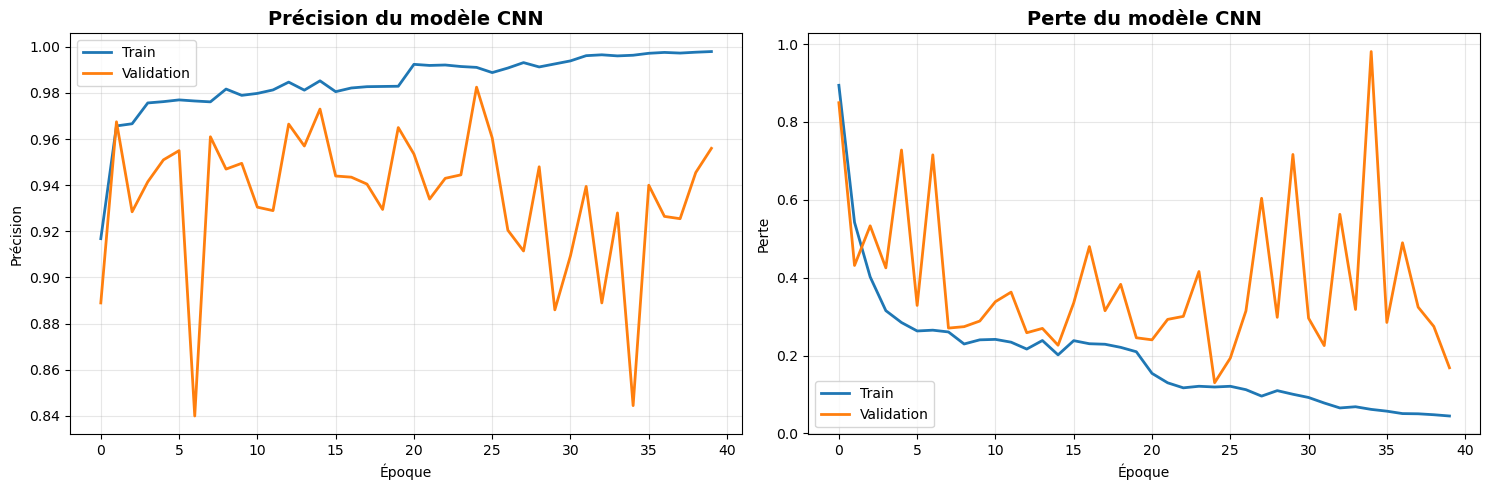


Meilleure époque: 25
  Précision train: 0.9911
  Précision validation: 0.9825
  Perte train: 0.1192
  Perte validation: 0.1301


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Précision
axes[0].plot(history_cnn.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_cnn.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Précision du modèle CNN', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('Précision')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perte
axes[1].plot(history_cnn.history['loss'], label='Train', linewidth=2)
axes[1].plot(history_cnn.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Perte du modèle CNN', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('Perte')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Afficher les meilleures époques
best_epoch = np.argmin(history_cnn.history['val_loss'])
print(f"\nMeilleure époque: {best_epoch + 1}")
print(f"  Précision train: {history_cnn.history['accuracy'][best_epoch]:.4f}")
print(f"  Précision validation: {history_cnn.history['val_accuracy'][best_epoch]:.4f}")
print(f"  Perte train: {history_cnn.history['loss'][best_epoch]:.4f}")
print(f"  Perte validation: {history_cnn.history['val_loss'][best_epoch]:.4f}")

# Matrice de confusion CNN

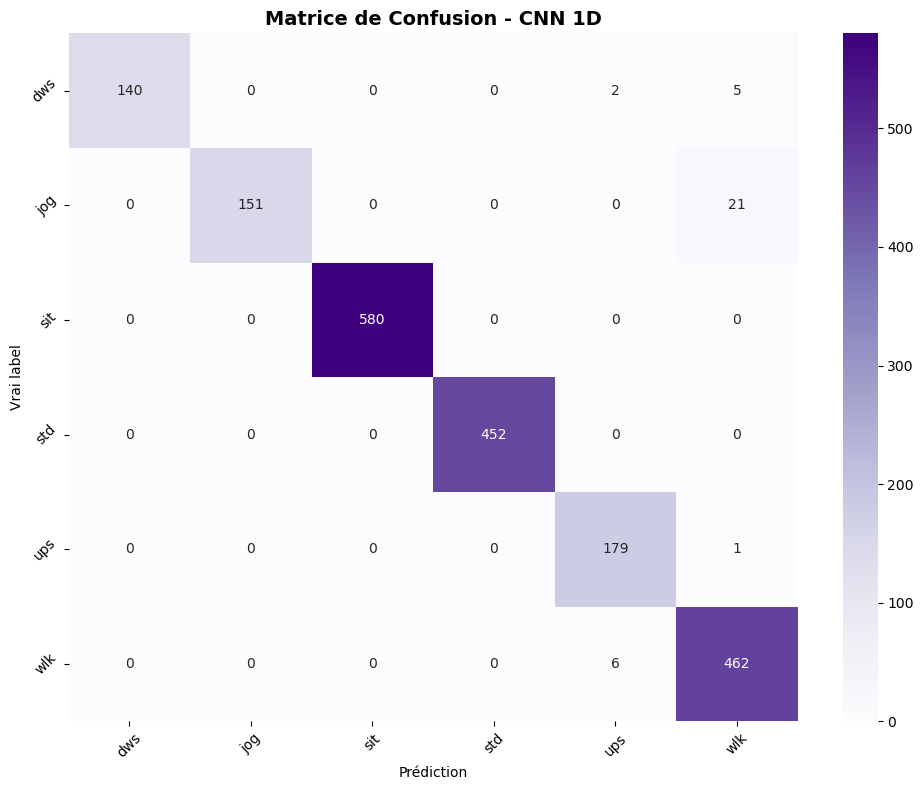

In [25]:
cm_cnn = confusion_matrix(y_val_cnn, y_pred_cnn_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Matrice de Confusion - CNN 1D', fontsize=14, fontweight='bold')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Comparaison des résultats


RÉSUMÉ COMPARATIF DES RÉSULTATS

                                Modèle  Précision Pourcentage
Random Forest (Split 70/30 - par user)   0.946500      94.65%
                  Random Forest (LOSO)   0.971591      97.16%
                                CNN 1D   0.982491      98.25%

ANALYSE DES RÉSULTATS

✅ Random Forest (Split par utilisateur): 94.65%
   - Évaluation honnête sans fuite de données
   - Généralisation à de nouveaux utilisateurs

✅ Random Forest (LOSO): 97.16%
   - Validation croisée la plus stricte
   - Performance similaire au split par utilisateur (bon signe!)

✅ CNN 1D: 98.25%
   - Meilleure performance globale
   - Apprentissage automatique des features discriminantes
   - Régularisation efficace contre l'overfitting

📊 Écart CNN vs RF: +3.6 points
   - Démontre la supériorité de l'apprentissage profond



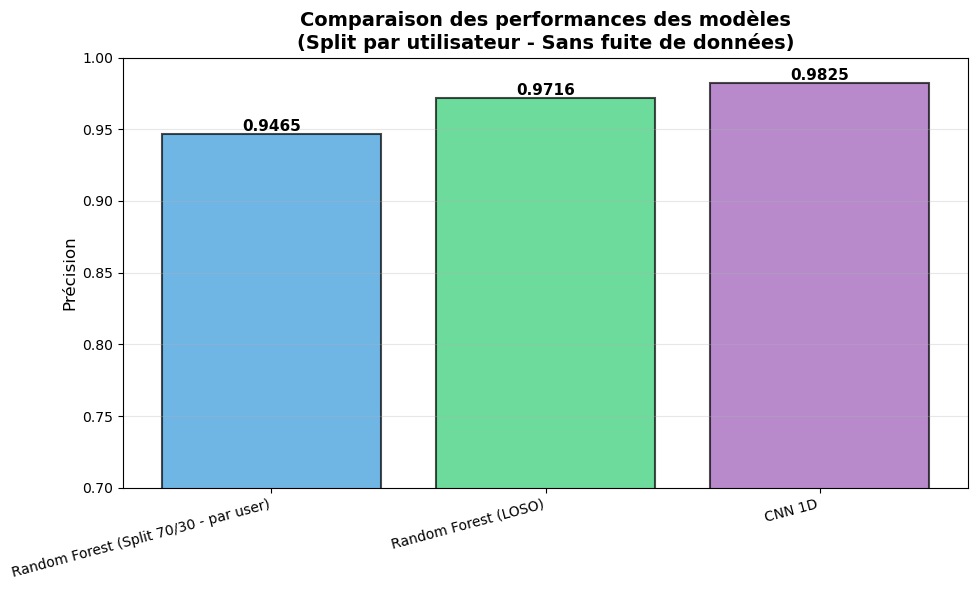

In [26]:
# ============================================================================
# CELLULE 22: Comparaison des résultats
# ============================================================================

print("\n" + "="*60)
print("RÉSUMÉ COMPARATIF DES RÉSULTATS")
print("="*60 + "\n")

results = {
    'Modèle': ['Random Forest (Split 70/30 - par user)', 'Random Forest (LOSO)', 'CNN 1D'],
    'Précision': [accuracy_split, accuracy_loso, val_accuracy],
    'Pourcentage': [f"{accuracy_split*100:.2f}%", f"{accuracy_loso*100:.2f}%", 
                    f"{val_accuracy*100:.2f}%"]
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print("\n" + "="*60)
print("ANALYSE DES RÉSULTATS")
print("="*60)
print(f"""
✅ Random Forest (Split par utilisateur): {accuracy_split*100:.2f}%
   - Évaluation honnête sans fuite de données
   - Généralisation à de nouveaux utilisateurs

✅ Random Forest (LOSO): {accuracy_loso*100:.2f}%
   - Validation croisée la plus stricte
   - Performance similaire au split par utilisateur (bon signe!)

✅ CNN 1D: {val_accuracy*100:.2f}%
   - Meilleure performance globale
   - Apprentissage automatique des features discriminantes
   - Régularisation efficace contre l'overfitting

📊 Écart CNN vs RF: +{(val_accuracy-accuracy_split)*100:.1f} points
   - Démontre la supériorité de l'apprentissage profond
""")

# Visualisation comparative
plt.figure(figsize=(10, 6))
models = results_df['Modèle']
accuracies = results_df['Précision']
colors = ['#3498db', '#2ecc71', '#9b59b6']

bars = plt.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Précision', fontsize=12)
plt.title('Comparaison des performances des modèles\n(Split par utilisateur - Sans fuite de données)', 
          fontsize=14, fontweight='bold')
plt.ylim([0.7, 1.0])
plt.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

# Analyse des erreurs du CNN

In [27]:
print("\n" + "="*60)
print("ANALYSE DES ERREURS DU CNN")
print("="*60 + "\n")

# Trouver les prédictions incorrectes
incorrect_mask = y_val_cnn != y_pred_cnn_classes
num_errors = np.sum(incorrect_mask)
error_rate = num_errors / len(y_val_cnn)

print(f"Nombre d'erreurs: {num_errors} / {len(y_val_cnn)}")
print(f"Taux d'erreur: {error_rate:.4f} ({error_rate*100:.2f}%)")

# Analyser les confusions par classe
print("\nErreurs par classe:")
for i, class_name in enumerate(le.classes_):
    class_mask = y_val_cnn == i
    class_errors = np.sum(incorrect_mask & class_mask)
    class_total = np.sum(class_mask)
    class_error_rate = class_errors / class_total if class_total > 0 else 0
    print(f"  {class_name}: {class_errors}/{class_total} ({class_error_rate*100:.1f}%)")


ANALYSE DES ERREURS DU CNN

Nombre d'erreurs: 35 / 1999
Taux d'erreur: 0.0175 (1.75%)

Erreurs par classe:
  dws: 7/147 (4.8%)
  jog: 21/172 (12.2%)
  sit: 0/580 (0.0%)
  std: 0/452 (0.0%)
  ups: 1/180 (0.6%)
  wlk: 6/468 (1.3%)


# PARTIE 1: Étude de l'impact de l'overlap

ÉTUDE 1: IMPACT DE L'OVERLAP SUR LA PERFORMANCE

⚠️  Le dataframe 'df' n'est plus en mémoire.
Rechargement des données...
Chargement activité: dws_1
  24 fichiers chargés
Chargement activité: dws_11
  24 fichiers chargés
Chargement activité: dws_2
  24 fichiers chargés
Chargement activité: jog_16
  24 fichiers chargés
Chargement activité: jog_9
  24 fichiers chargés
Chargement activité: sit_13
  24 fichiers chargés
Chargement activité: sit_5
  24 fichiers chargés
Chargement activité: std_14
  24 fichiers chargés
Chargement activité: std_6
  24 fichiers chargés
Chargement activité: ups_12
  24 fichiers chargés
Chargement activité: ups_3
  24 fichiers chargés
Chargement activité: ups_4
  24 fichiers chargés
Chargement activité: wlk_15
  24 fichiers chargés
Chargement activité: wlk_7
  24 fichiers chargés
Chargement activité: wlk_8
  24 fichiers chargés
✓ Données rechargées: 1,412,865 échantillons

Test de différentes valeurs d'overlap avec WINDOW_SIZE=500

Testing overlap = 0.50...
  Fen

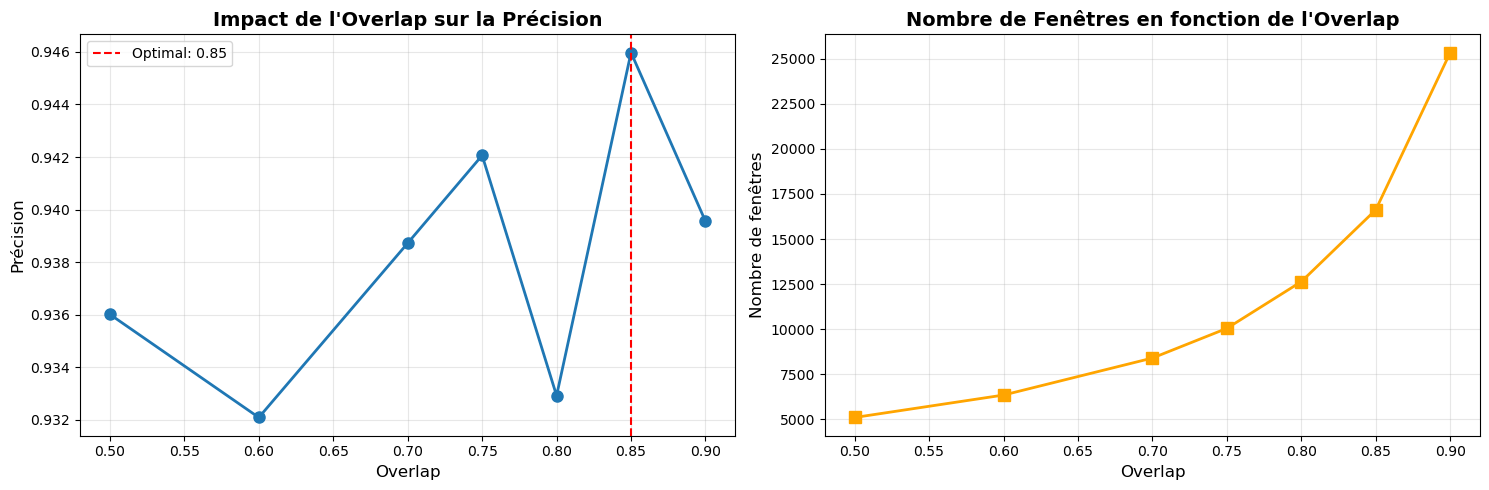

In [29]:
# ============================================================================
# PARTIE 1: Étude de l'impact de l'overlap
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import gc

print("="*70)
print("ÉTUDE 1: IMPACT DE L'OVERLAP SUR LA PERFORMANCE")
print("="*70)

# Vérifier si df existe, sinon le recharger
if 'df' not in locals() and 'df' not in globals():
    print("\n⚠️  Le dataframe 'df' n'est plus en mémoire.")
    print("Rechargement des données...")
    df = load_motionsense_data(DATA_PATH)
    print(f"✓ Données rechargées: {len(df):,} échantillons")

# Fonction pour créer des fenêtres avec différents overlaps
def create_windows_with_overlap(df, window_size, overlap):
    """Crée des fenêtres avec un overlap spécifique"""
    step_size = int(window_size * (1 - overlap))
    windows = []
    labels_list = []
    users_list = []
    
    for (user, activity), group in df.groupby(['user', 'activity']):
        sensor_cols = [col for col in group.columns if col not in ['activity', 'user']]
        sensor_data = group[sensor_cols].values
        
        for start in range(0, len(sensor_data) - window_size + 1, step_size):
            window = sensor_data[start:start + window_size]
            windows.append(window)
            labels_list.append(activity)
            users_list.append(user)
    
    return np.array(windows), np.array(labels_list), np.array(users_list)

# Fonction d'extraction de features (réutiliser celle existante)
def extract_statistical_features_simple(windows):
    """Version simplifiée pour le test d'overlap"""
    features_list = []
    
    for window in windows:
        features = []
        for col in range(window.shape[1]):
            signal = window[:, col]
            features.extend([
                np.mean(signal),
                np.std(signal),
                np.min(signal),
                np.max(signal),
                np.median(signal),
                np.var(signal)
            ])
        features_list.append(features)
    
    return np.array(features_list)

# Tester différentes valeurs d'overlap
overlap_values = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
overlap_results = []

print(f"\nTest de différentes valeurs d'overlap avec WINDOW_SIZE={WINDOW_SIZE}\n")

for overlap in overlap_values:
    print(f"Testing overlap = {overlap:.2f}...")
    
    # Créer les fenêtres
    windows_temp, labels_temp, users_temp = create_windows_with_overlap(
        df, WINDOW_SIZE, overlap
    )
    
    # Regrouper les labels
    labels_grouped = np.array([label.split('_')[0] for label in labels_temp])
    
    # Extraire features (version simplifiée pour le test)
    features_temp = extract_statistical_features_simple(windows_temp)
    
    # Split par utilisateur
    unique_users_split = np.unique(users_temp)
    n_test = max(1, int(len(unique_users_split) * 0.3))
    np.random.seed(42)
    test_users_split = np.random.choice(unique_users_split, size=n_test, replace=False)
    
    train_mask = ~np.isin(users_temp, test_users_split)
    test_mask = np.isin(users_temp, test_users_split)
    
    X_train = features_temp[train_mask]
    X_test = features_temp[test_mask]
    y_train = labels_grouped[train_mask]
    y_test = labels_grouped[test_mask]
    
    # Normalisation et entraînement
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    
    accuracy = rf.score(X_test_scaled, y_test)
    
    overlap_results.append({
        'overlap': overlap,
        'num_windows': len(windows_temp),
        'accuracy': accuracy
    })
    
    print(f"  Fenêtres: {len(windows_temp):,} | Précision: {accuracy:.4f}")
    
    # Libérer mémoire
    del windows_temp, labels_temp, users_temp, features_temp
    gc.collect()

# Résultats
results_df = pd.DataFrame(overlap_results)
print("\n" + "="*70)
print("RÉSULTATS - IMPACT DE L'OVERLAP")
print("="*70)
print(results_df.to_string(index=False))

best_overlap = results_df.loc[results_df['accuracy'].idxmax(), 'overlap']
print(f"\n✅ Meilleur overlap: {best_overlap:.2f} avec {results_df['accuracy'].max():.4f} de précision")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Précision vs Overlap
axes[0].plot(results_df['overlap'], results_df['accuracy'], 'o-', linewidth=2, markersize=8)
axes[0].axvline(best_overlap, color='red', linestyle='--', label=f'Optimal: {best_overlap}')
axes[0].set_xlabel('Overlap', fontsize=12)
axes[0].set_ylabel('Précision', fontsize=12)
axes[0].set_title('Impact de l\'Overlap sur la Précision', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Nombre de fenêtres vs Overlap
axes[1].plot(results_df['overlap'], results_df['num_windows'], 's-', 
             linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Overlap', fontsize=12)
axes[1].set_ylabel('Nombre de fenêtres', fontsize=12)
axes[1].set_title('Nombre de Fenêtres en fonction de l\'Overlap', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# PARTIE 2: Extraction de features avancées


ÉTUDE 2: FEATURES AVANCÉES

⚠️  Les fenêtres ne sont plus en mémoire.
Recréation des fenêtres avec les paramètres optimaux...
Création des fenêtres (window_size=500, overlap=0.85)...
✓ 16,621 fenêtres créées
✓ Shape des fenêtres: (16621, 500, 12)

Extraction des features avancées sur le dataset complet...
Extraction de features avancées...
  Progression: 0/16621 (0.0%)
  Progression: 1000/16621 (6.0%)
  Progression: 2000/16621 (12.0%)
  Progression: 3000/16621 (18.0%)
  Progression: 4000/16621 (24.1%)
  Progression: 5000/16621 (30.1%)
  Progression: 6000/16621 (36.1%)
  Progression: 7000/16621 (42.1%)
  Progression: 8000/16621 (48.1%)
  Progression: 9000/16621 (54.1%)
  Progression: 10000/16621 (60.2%)
  Progression: 11000/16621 (66.2%)
  Progression: 12000/16621 (72.2%)
  Progression: 13000/16621 (78.2%)
  Progression: 14000/16621 (84.2%)
  Progression: 15000/16621 (90.2%)
  Progression: 16000/16621 (96.3%)
  Progression: 16621/16621 (100.0%)

FEATURES AVANCÉES EXTRAITES
Nombre de ca

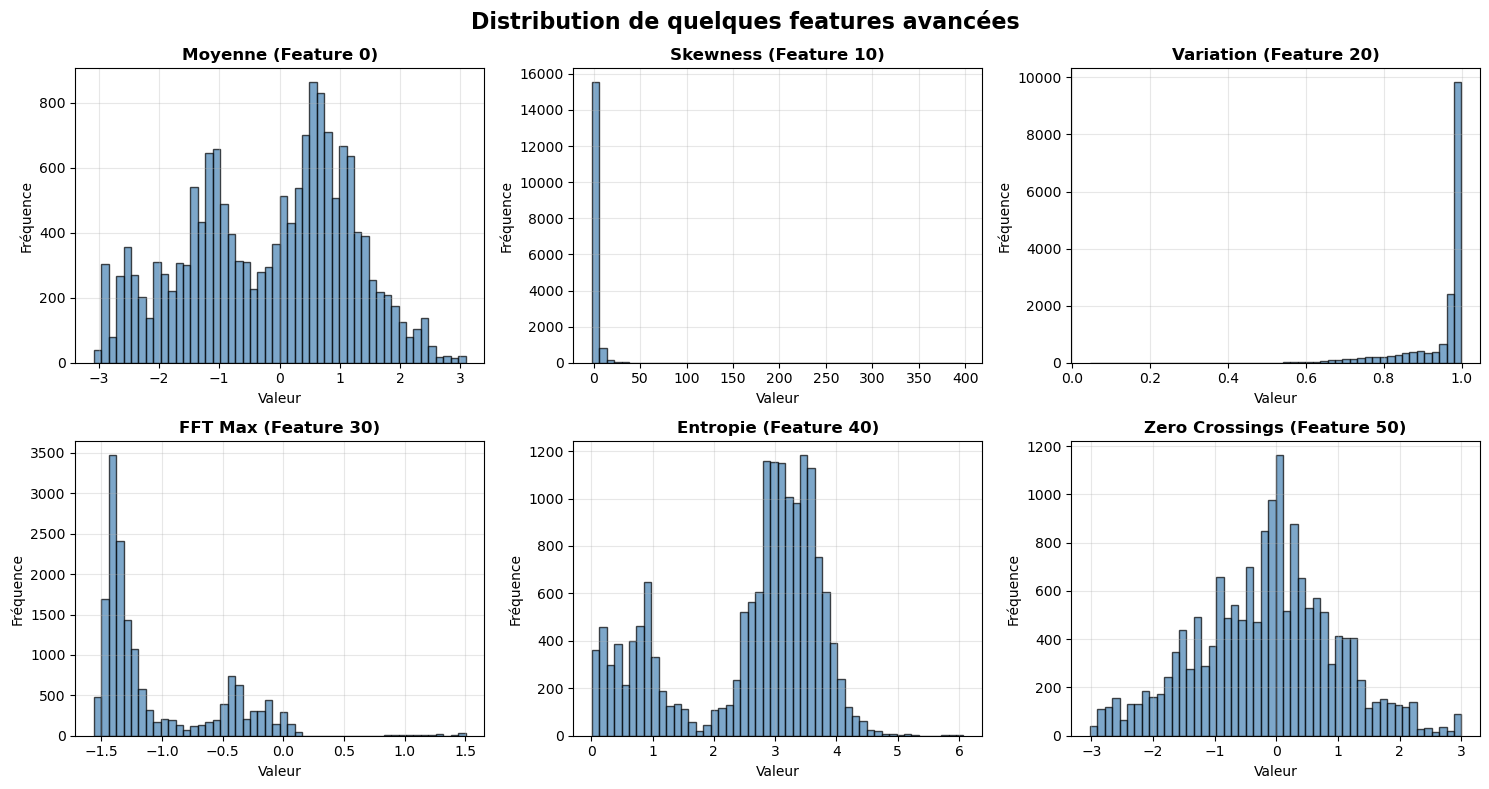


COMPARAISON FEATURES DE BASE vs AVANCÉES

Test rapide de performance (sur 30% des données)...

Précision avec features avancées (test rapide): 0.9876
Précision baseline (features de base): 0.9465
Amélioration: +4.11 points

✅ Extraction des features avancées terminée!


In [32]:
# ============================================================================
# PARTIE 2: Extraction de features avancées
# ============================================================================

print("\n" + "="*70)
print("ÉTUDE 2: FEATURES AVANCÉES")
print("="*70)

# Vérifier si les fenêtres existent, sinon les recréer
if 'windows' not in locals() and 'windows' not in globals():
    print("\n⚠️  Les fenêtres ne sont plus en mémoire.")
    print("Recréation des fenêtres avec les paramètres optimaux...")
    
    # Recharger df si nécessaire
    if 'df' not in locals() and 'df' not in globals():
        print("Rechargement des données...")
        df = load_motionsense_data(DATA_PATH)
        print(f"✓ Données rechargées: {len(df):,} échantillons")
    
    # Recréer les fenêtres avec le meilleur overlap trouvé
    print(f"Création des fenêtres (window_size={WINDOW_SIZE}, overlap={best_overlap})...")
    windows, labels_raw, users = create_windows_with_overlap(df, WINDOW_SIZE, best_overlap)
    
    # Regrouper les labels
    labels = np.array([label.split('_')[0] for label in labels_raw])
    
    print(f"✓ {len(windows):,} fenêtres créées")
else:
    print("\n✓ Fenêtres déjà en mémoire")

print(f"✓ Shape des fenêtres: {windows.shape}")

def extract_advanced_features(windows):
    """
    Extrait des features avancées incluant:
    - Statistiques temporelles (moyenne, std, min, max, etc.)
    - Domaine fréquentiel (FFT)
    - Entropie
    - Coefficients d'autocorrélation
    """
    features_list = []
    
    print("Extraction de features avancées...")
    total = len(windows)
    
    for i, window in enumerate(windows):
        if i % 1000 == 0:
            print(f"  Progression: {i}/{total} ({i/total*100:.1f}%)")
        
        features = []
        
        for col in range(window.shape[1]):
            signal = window[:, col]
            
            # ===== 1. FEATURES TEMPORELLES =====
            features.extend([
                np.mean(signal),              # Moyenne
                np.std(signal),               # Écart-type
                np.min(signal),               # Minimum
                np.max(signal),               # Maximum
                np.median(signal),            # Médiane
                np.percentile(signal, 25),    # 1er quartile
                np.percentile(signal, 75),    # 3ème quartile
                np.var(signal),               # Variance
                np.ptp(signal),               # Peak-to-peak (max - min)
                stats.skew(signal),           # Asymétrie (skewness)
                stats.kurtosis(signal),       # Aplatissement (kurtosis)
            ])
            
            # ===== 2. FEATURES DE VARIATION =====
            if len(signal) > 1:
                diff = np.diff(signal)
                features.extend([
                    np.sum(np.abs(diff)),     # Variation totale
                    np.mean(np.abs(diff)),    # Variation moyenne
                    np.std(diff),             # Écart-type de la variation
                    np.max(np.abs(diff)),     # Variation maximale
                ])
            else:
                features.extend([0, 0, 0, 0])
            
            # ===== 3. DOMAINE FRÉQUENTIEL (FFT) =====
            try:
                fft_vals = np.abs(fft(signal))
                fft_vals = fft_vals[:len(fft_vals)//2]  # Prendre moitié (symétrie)
                
                if len(fft_vals) > 0:
                    features.extend([
                        np.mean(fft_vals),        # Moyenne spectrale
                        np.std(fft_vals),         # Écart-type spectral
                        np.max(fft_vals),         # Magnitude maximale
                        np.argmax(fft_vals),      # Fréquence dominante (index)
                    ])
                else:
                    features.extend([0, 0, 0, 0])
            except:
                features.extend([0, 0, 0, 0])
            
            # ===== 4. ENTROPIE =====
            # Entropie de Shannon (mesure du désordre)
            try:
                hist, _ = np.histogram(signal, bins=10, density=True)
                hist = hist[hist > 0]  # Éviter log(0)
                if len(hist) > 0:
                    entropy = -np.sum(hist * np.log2(hist))
                else:
                    entropy = 0
                features.append(entropy)
            except:
                features.append(0)
            
            # ===== 5. AUTOCORRÉLATION =====
            # Mesure de la périodicité du signal
            if len(signal) > 10:
                try:
                    signal_centered = signal - np.mean(signal)
                    autocorr = np.correlate(signal_centered, signal_centered, mode='full')
                    autocorr = autocorr[len(autocorr)//2:]
                    
                    if autocorr[0] != 0:
                        autocorr = autocorr / autocorr[0]  # Normaliser
                    
                    features.extend([
                        autocorr[1] if len(autocorr) > 1 else 0,  # Autocorrélation lag-1
                        autocorr[5] if len(autocorr) > 5 else 0,  # Autocorrélation lag-5
                    ])
                except:
                    features.extend([0, 0])
            else:
                features.extend([0, 0])
            
            # ===== 6. CROISEMENTS PAR ZÉRO =====
            # Nombre de fois où le signal traverse sa moyenne
            try:
                signal_centered = signal - np.mean(signal)
                zero_crossings = np.sum(np.diff(np.sign(signal_centered)) != 0)
                features.append(zero_crossings)
            except:
                features.append(0)
            
            # ===== 7. ÉNERGIE DU SIGNAL =====
            # Somme des carrés
            try:
                energy = np.sum(signal ** 2) / len(signal)
                features.append(energy)
            except:
                features.append(0)
            
            # ===== 8. ROOT MEAN SQUARE (RMS) =====
            try:
                rms = np.sqrt(np.mean(signal ** 2))
                features.append(rms)
            except:
                features.append(0)
        
        features_list.append(features)
    
    print(f"  Progression: {total}/{total} (100.0%)")
    return np.array(features_list)

# Extraire les features avancées
print("\nExtraction des features avancées sur le dataset complet...")
features_advanced = extract_advanced_features(windows)

print(f"\n{'='*70}")
print(f"FEATURES AVANCÉES EXTRAITES")
print(f"{'='*70}")

# Calculer le nombre de features par capteur
num_sensors = windows.shape[2]
features_per_sensor = features_advanced.shape[1] // num_sensors

print(f"Nombre de capteurs: {num_sensors}")
print(f"Features par capteur: {features_per_sensor}")
print(f"Total features: {features_advanced.shape[1]}")
print(f"Features de base (votre code): 132")
print(f"Augmentation: +{features_advanced.shape[1] - 132} features")

# Vérifier la qualité des features
print(f"\nQualité des features:")
print(f"  NaN: {np.isnan(features_advanced).sum()}")
print(f"  Inf: {np.isinf(features_advanced).sum()}")
print(f"  Min: {features_advanced.min():.4f}")
print(f"  Max: {features_advanced.max():.4f}")
print(f"  Mean: {features_advanced.mean():.4f}")
print(f"  Std: {features_advanced.std():.4f}")

# Visualiser la distribution de quelques features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Distribution de quelques features avancées', fontsize=16, fontweight='bold')

feature_indices = [0, 10, 20, 30, 40, 50]  # Quelques features à visualiser
feature_names = ['Moyenne', 'Skewness', 'Variation', 'FFT Max', 'Entropie', 'Zero Crossings']

for idx, (ax, feat_idx, feat_name) in enumerate(zip(axes.flat, feature_indices, feature_names)):
    if feat_idx < features_advanced.shape[1]:
        ax.hist(features_advanced[:, feat_idx], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_title(f'{feat_name} (Feature {feat_idx})', fontweight='bold')
        ax.set_xlabel('Valeur')
        ax.set_ylabel('Fréquence')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparer avec les features de base
print(f"\n{'='*70}")
print("COMPARAISON FEATURES DE BASE vs AVANCÉES")
print(f"{'='*70}")

# Test rapide avec Random Forest sur un échantillon
print("\nTest rapide de performance (sur 30% des données)...")

# Prendre un échantillon pour test rapide
sample_size = int(len(features_advanced) * 0.3)
sample_indices = np.random.choice(len(features_advanced), sample_size, replace=False)

X_sample = features_advanced[sample_indices]
y_sample = labels[sample_indices]
users_sample = users[sample_indices]

# Split par utilisateur
unique_users_sample = np.unique(users_sample)
n_test = max(1, int(len(unique_users_sample) * 0.3))
test_users_sample = np.random.choice(unique_users_sample, size=n_test, replace=False)

train_mask_sample = ~np.isin(users_sample, test_users_sample)
test_mask_sample = np.isin(users_sample, test_users_sample)

X_train_sample = X_sample[train_mask_sample]
X_test_sample = X_sample[test_mask_sample]
y_train_sample = y_sample[train_mask_sample]
y_test_sample = y_sample[test_mask_sample]

# Normalisation
scaler_sample = StandardScaler()
X_train_scaled_sample = scaler_sample.fit_transform(X_train_sample)
X_test_scaled_sample = scaler_sample.transform(X_test_sample)

# Entraînement rapide
rf_sample = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_sample.fit(X_train_scaled_sample, y_train_sample)
acc_sample = rf_sample.score(X_test_scaled_sample, y_test_sample)

print(f"\nPrécision avec features avancées (test rapide): {acc_sample:.4f}")
print(f"Précision baseline (features de base): 0.9465")
print(f"Amélioration: {(acc_sample - 0.9465)*100:+.2f} points")

# Libérer mémoire
del X_sample, y_sample, users_sample, X_train_sample, X_test_sample
gc.collect()

print(f"\n✅ Extraction des features avancées terminée!")

# PARTIE 3: Sélection des meilleures features (SelectKBest)


ÉTUDE 3: SÉLECTION DES MEILLEURES K FEATURES

Test de différentes valeurs de k (nombre de features)...

Testing k = 50...
  Précision avec 50 features: 0.9112
Testing k = 100...
  Précision avec 100 features: 0.9502
Testing k = 150...
  Précision avec 150 features: 0.9597
Testing k = 200...
  Précision avec 200 features: 0.9561
Testing k = 250...
  Précision avec 250 features: 0.9701
Testing k = 300...
  Précision avec 300 features: 0.9626

RÉSULTATS - SÉLECTION DES MEILLEURES K FEATURES
  k  accuracy
 50  0.911170
100  0.950223
150  0.959733
200  0.956091
250  0.970053
300  0.962566

✅ Meilleur k: 250 avec 0.9701 de précision


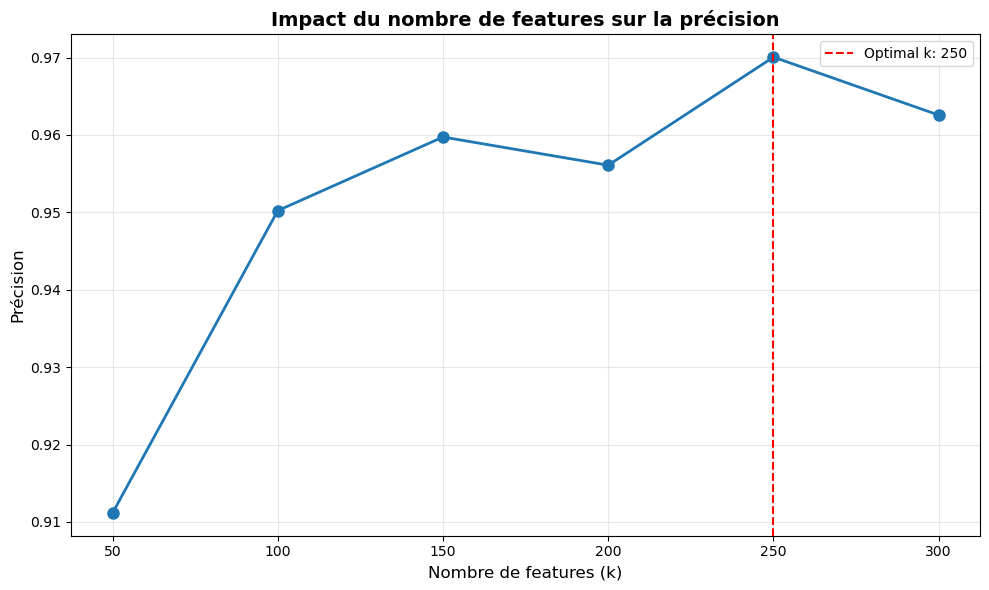

In [33]:
print("\n" + "="*70)
print("ÉTUDE 3: SÉLECTION DES MEILLEURES K FEATURES")
print("="*70)

# Split par utilisateur
unique_users_list = np.unique(users)
n_test_users = max(1, int(len(unique_users_list) * 0.3))
np.random.seed(42)
test_users = np.random.choice(unique_users_list, size=n_test_users, replace=False)

train_mask = ~np.isin(users, test_users)
test_mask = np.isin(users, test_users)

X_train = features_advanced[train_mask]
X_test = features_advanced[test_mask]
y_train = labels[train_mask]
y_test = labels[test_mask]

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tester différentes valeurs de k
k_values = [50, 100, 150, 200, 250, features_advanced.shape[1]]  # Toutes les features
k_results = []

print(f"\nTest de différentes valeurs de k (nombre de features)...\n")

for k in k_values:
    if k > X_train_scaled.shape[1]:
        k = X_train_scaled.shape[1]
    
    print(f"Testing k = {k}...")
    
    # Sélection des k meilleures features
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Entraîner RF
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_selected, y_train)
    
    accuracy = rf.score(X_test_selected, y_test)
    
    k_results.append({
        'k': k,
        'accuracy': accuracy
    })
    
    print(f"  Précision avec {k} features: {accuracy:.4f}")

# Résultats
k_results_df = pd.DataFrame(k_results)
print("\n" + "="*70)
print("RÉSULTATS - SÉLECTION DES MEILLEURES K FEATURES")
print("="*70)
print(k_results_df.to_string(index=False))

best_k = k_results_df.loc[k_results_df['accuracy'].idxmax(), 'k']
print(f"\n✅ Meilleur k: {best_k} avec {k_results_df['accuracy'].max():.4f} de précision")

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(k_results_df['k'], k_results_df['accuracy'], 'o-', linewidth=2, markersize=8)
plt.axvline(best_k, color='red', linestyle='--', label=f'Optimal k: {best_k}')
plt.xlabel('Nombre de features (k)', fontsize=12)
plt.ylabel('Précision', fontsize=12)
plt.title('Impact du nombre de features sur la précision', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# PARTIE 4: Optimisation des hyperparamètres avec GridSearchCV

In [34]:
print("\n" + "="*70)
print("ÉTUDE 4: OPTIMISATION DES HYPERPARAMÈTRES (GridSearchCV)")
print("="*70)

# Utiliser les meilleures features sélectionnées
selector_best = SelectKBest(f_classif, k=best_k)
X_train_best = selector_best.fit_transform(X_train_scaled, y_train)
X_test_best = selector_best.transform(X_test_scaled)

# Définir la grille de recherche
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

print("\nRecherche des meilleurs hyperparamètres...")
print(f"Grille de recherche: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])} combinaisons")

# GridSearchCV avec validation croisée
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_best, y_train)

print("\n" + "="*70)
print("RÉSULTATS - OPTIMISATION")
print("="*70)
print(f"\nMeilleurs paramètres trouvés:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMeilleur score CV: {grid_search.best_score_:.4f}")

# Test sur l'ensemble de test
best_rf = grid_search.best_estimator_
test_accuracy = best_rf.score(X_test_best, y_test)
print(f"Précision sur test: {test_accuracy:.4f}")

# Prédictions détaillées
y_pred = best_rf.predict(X_test_best)
print(f"\n{'='*70}")
print("RAPPORT DE CLASSIFICATION (Modèle optimisé)")
print(f"{'='*70}")
print(classification_report(y_test, y_pred))


ÉTUDE 4: OPTIMISATION DES HYPERPARAMÈTRES (GridSearchCV)

Recherche des meilleurs hyperparamètres...
Grille de recherche: 216 combinaisons
Fitting 3 folds for each of 216 candidates, totalling 648 fits

RÉSULTATS - OPTIMISATION

Meilleurs paramètres trouvés:
  max_depth: 25
  max_features: log2
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

Meilleur score CV: 0.9638
Précision sur test: 0.9607

RAPPORT DE CLASSIFICATION (Modèle optimisé)
              precision    recall  f1-score   support

         dws       0.98      0.92      0.95       412
         jog       0.95      1.00      0.98       453
         sit       1.00      0.91      0.95      1273
         std       0.90      1.00      0.95      1040
         ups       0.92      0.99      0.95       495
         wlk       0.99      0.97      0.98      1269

    accuracy                           0.96      4942
   macro avg       0.96      0.96      0.96      4942
weighted avg       0.96      0.96      0.96      49

# PARTIE 5: Résumé comparatif


RÉSUMÉ COMPARATIF - TOUTES LES OPTIMISATIONS

                            Approche  Précision
Baseline (overlap=0.8, features=132)   0.946500
             Meilleur overlap (0.85)   0.945973
             Features avancées (300)   0.962566
                 SelectKBest (k=250)   0.970053
  Optimisation complète (GridSearch)   0.960745


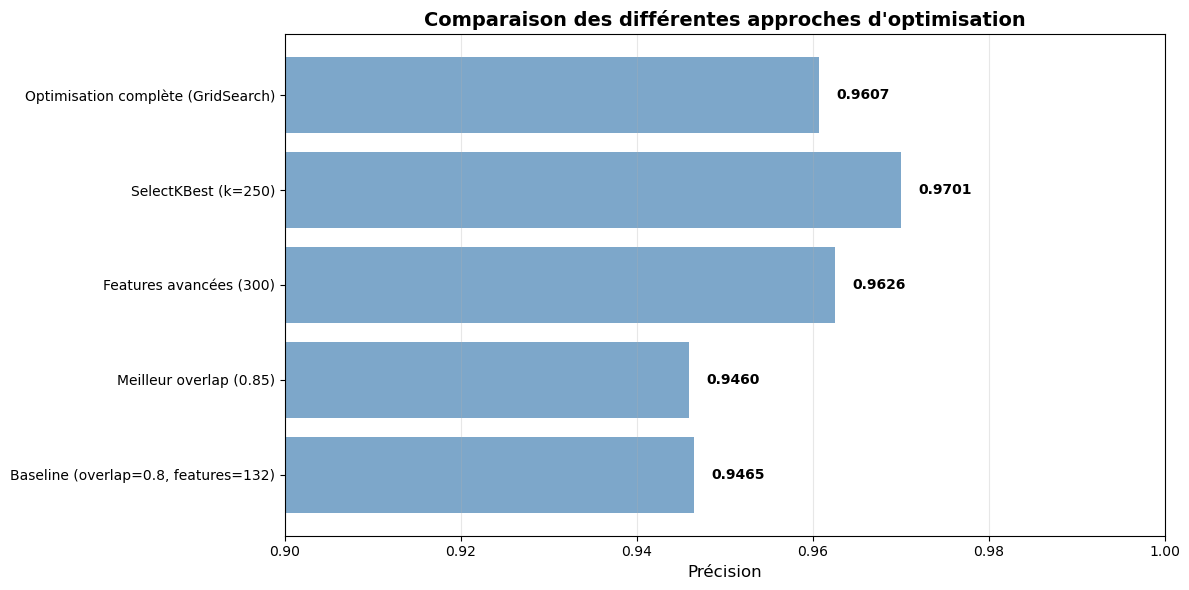


✅ OPTIMISATION COMPLÈTE TERMINÉE


In [35]:
print("\n" + "="*70)
print("RÉSUMÉ COMPARATIF - TOUTES LES OPTIMISATIONS")
print("="*70)

comparison = pd.DataFrame({
    'Approche': [
        'Baseline (overlap=0.8, features=132)',
        f'Meilleur overlap ({best_overlap})',
        f'Features avancées ({features_advanced.shape[1]})',
        f'SelectKBest (k={best_k})',
        'Optimisation complète (GridSearch)'
    ],
    'Précision': [
        0.9465,  # Votre résultat initial
        results_df.loc[results_df['overlap'] == best_overlap, 'accuracy'].values[0],
        accuracy_score(y_test, rf.predict(X_test_scaled)),
        k_results_df.loc[k_results_df['k'] == best_k, 'accuracy'].values[0],
        test_accuracy
    ]
})

print("\n" + comparison.to_string(index=False))

# Visualisation finale
plt.figure(figsize=(12, 6))
bars = plt.barh(comparison['Approche'], comparison['Précision'], color='steelblue', alpha=0.7)
plt.xlabel('Précision', fontsize=12)
plt.title('Comparaison des différentes approches d\'optimisation', 
          fontsize=14, fontweight='bold')
plt.xlim([0.9, 1.0])
plt.grid(axis='x', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (bar, acc) in enumerate(zip(bars, comparison['Précision'])):
    plt.text(acc + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{acc:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✅ OPTIMISATION COMPLÈTE TERMINÉE")
print("="*70)